In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data access

In [2]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [3]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

### setup data

In [4]:
staging_dir = Path("vo_agam_staging")
species_analysis = "species_calls_20200422"

In [45]:
with open("../data/config.yml", "r") as yy:
    config = yaml.load(yy, Loader=yaml.Loader)

samplesets = sorted(config["sample_sets"])

#GA-B is empty, crosses we don't want
samplesets.remove('AG1000G-GA-B')

In [48]:
#need to get mean lon/lat across countries so we might as well concat all metadata including species into a big PD

set_len = 0
all_meta = pd.DataFrame()

for sset in samplesets:
        
        metadata_path = staging_dir / "v3" / "metadata" / "general" / sset / "samples.meta.csv"
        species_path = staging_dir / "v3" / "metadata" / species_analysis / sset / "samples.species_aim.csv"


        with gcs.open(metadata_path) as gcs_fh:
            df = pd.read_csv(gcs_fh, index_col=0)
        with gcs.open(species_path) as gcs_fh:
            df_aim = pd.read_csv(gcs_fh, index_col=0)

        # join on sample id
        result = pd.concat([df, df_aim], axis=1, sort=False)
        set_len += len(result)

        all_meta = pd.concat([all_meta, result],sort=False)

assert len(all_meta) == set_len

In [49]:
all_meta

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii
sample_id,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.945,0.001,gamb_colu,coluzzii
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.933,0.001,gamb_colu,coluzzii
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.937,0.002,gamb_colu,coluzzii
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.938,0.002,gamb_colu,coluzzii
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.926,0.001,gamb_colu,coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AD0733-C,SENN_F_-_DONG_M_Fam1z_28,Martin Donnelly,Lab Cross,LSTM,-1,-1,53.409,-2.969,F,NaN,NaN,NaN,NaN
AD0734-C,SENN_F_-_DONG_M_Fam1z_29,Martin Donnelly,Lab Cross,LSTM,-1,-1,53.409,-2.969,F,NaN,NaN,NaN,NaN
AD0735-C,SENN_F_-_DONG_M_Fam1z_30,Martin Donnelly,Lab Cross,LSTM,-1,-1,53.409,-2.969,F,NaN,NaN,NaN,NaN


In [50]:
all_meta[all_meta.country == 'Angola']

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii
sample_id,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.945,0.001,gamb_colu,coluzzii
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.933,0.001,gamb_colu,coluzzii
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.937,0.002,gamb_colu,coluzzii
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.938,0.002,gamb_colu,coluzzii
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.926,0.001,gamb_colu,coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AR0018-Cx,LUA018,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.938,0.001,gamb_colu,coluzzii
AR0081-Cx,LUA081,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.929,0.001,gamb_colu,coluzzii
AR0013-Cx,LUA013,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.945,0.001,gamb_colu,coluzzii


In [42]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-22, 48, -25, 15], figsize=(10, 4), label_fontsize=7):
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=120)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=5)
    
    for sset in samplesets:
        if sset != "AG1000G-X":
            all_meta[all_me]


            with gcs.open(metadata_path) as gcs_fh:
                df = pd.read_csv(gcs_fh, index_col=0)

            #get an average lonlat for each country
            lon = [np.mean(df.longitude.unique())]
            lat = [np.mean(df.latitude.unique())]
            print(sset, lon, lat)

            centre = (lon[0], lat[0])
            radius=0.2
            ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='r', zorder=8, lw=1.5))

    ax.set_extent(extent)         
#     with gcs.open(species_path) as gcs_fh:
#         #         df_aim = pd.read_csv(gcs_fh, index_col=0)

AG1000G-AO [13.302] [-8.884]
AG1000G-BF-A [-4.414000000000001] [11.205999999999998]
AG1000G-BF-B [-4.414000000000001] [11.205999999999998]
AG1000G-BF-C [-1.17] [12.06]
AG1000G-CD [21.017] [4.283]
AG1000G-CF [18.583] [4.367]
AG1000G-CI [-4.823] [5.898]
AG1000G-CM-A [13.948] [4.955000000000001]
AG1000G-CM-B [13.228813559322035] [8.002916666666668]
AG1000G-CM-C [11.194700000000001] [5.277222222222222]
AG1000G-FR [45.129] [-12.816714285714285]
AG1000G-GA-A [9.455] [0.384]
AG1000G-GH [-0.9507500000000001] [5.57075]
AG1000G-GM-A [-15.9] [13.55]
AG1000G-GM-B [-15.850000000000001] [13.516666666666666]
AG1000G-GM-C [-14.917] [13.567]
AG1000G-GN-A [-9.78] [8.879999999999999]
AG1000G-GN-B [-8.924999999999999] [10.014999999999999]
AG1000G-GQ [8.7] [3.7]
AG1000G-GW [-15.151000000000002] [12.04]
AG1000G-KE [39.909] [-3.511]
AG1000G-ML-A [-8.13] [12.866666666666667]
AG1000G-ML-B [-7.398333333333333] [12.643333333333333]
AG1000G-MW [34.755] [-15.933]
AG1000G-MZ [35.299] [-23.715999999999998]
AG1000G-T

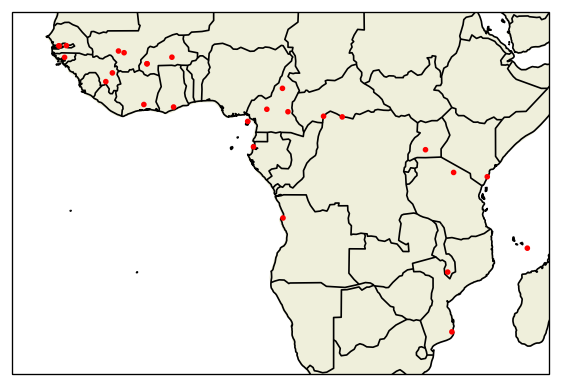

In [39]:
plot_pyr_map()

In [17]:
#sex as well as species?